In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from scipy.stats import ttest_ind

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="ipykernel.ipkernel")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
d4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Case Study_Scaler/DA Portfolio project/E-commerce Project_Raw data/Customers.csv')
d2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Case Study_Scaler/DA Portfolio project/E-commerce Project_Raw data/Discount_Coupon.csv')
marketing = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Case Study_Scaler/DA Portfolio project/E-commerce Project_Raw data/Marketing_Spend.csv')
sales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Case Study_Scaler/DA Portfolio project/E-commerce Project_Raw data/Online_Sales.csv')
d5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Case Study_Scaler/DA Portfolio project/E-commerce Project_Raw data/Tax_amount.csv')

**Problem Statement**

A fast-expanding e-commerce company is shifting from intuition-based marketing to a data-driven strategy. By analyzing customer demographics, transaction data, marketing spend, and discount details from 2019, the company aims to understand customer behavior. the company intends to refine its marketing tactics, better understand its customers, and foster long-term financial growth.

### **Data Pre-processing**

In [ ]:
sales.shape

(52924, 10)

In [ ]:
# Creating 'Month' column in Online_Sales data to merge with Discount_Coupon data
sales['Month'] = pd.to_datetime(sales['Transaction_Date']).dt.strftime('%b')

In [ ]:
# Merging Customers table, Discount_Coupon table and Tax_amount table with "Online_Sales" table. Renamed online_sales table as "Sales"
sales = sales.merge(d4, on='CustomerID', how='left').merge(d2, on=['Product_Category', 'Month'], how='left')
sales = sales.merge(d5, on='Product_Category', how='left')

In [ ]:
# Calculating total marketing spend and merging with 'Sales' data

marketing['marketing_spend'] = marketing['Offline_Spend']+marketing['Online_Spend']
marketing['Month'] = pd.to_datetime(marketing['Date']).dt.strftime('%b')
marketing_spend1 = marketing.groupby('Month')['marketing_spend'].sum().reset_index()
sales = sales.merge(marketing_spend1, on='Month', how='left')

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           52924 non-null  int64  
 1   Transaction_ID       52924 non-null  int64  
 2   Transaction_Date     52924 non-null  object 
 3   Product_SKU          52924 non-null  object 
 4   Product_Description  52924 non-null  object 
 5   Product_Category     52924 non-null  object 
 6   Quantity             52924 non-null  int64  
 7   Avg_Price            52924 non-null  float64
 8   Delivery_Charges     52924 non-null  float64
 9   Coupon_Status        52924 non-null  object 
 10  Month                52924 non-null  object 
 11  Gender               52924 non-null  object 
 12  Location             52924 non-null  object 
 13  Tenure_Months        52924 non-null  int64  
 14  Coupon_Code          52524 non-null  object 
 15  Discount_pct         52524 non-null 

In [ ]:
# Converting Datatypes as required

# Transaction_Date --> object to datetime
# CustomerID --> int64 to object
# Transaction_ID --> int64 to object
# GST --> object to float

sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'])
sales['CustomerID'] = sales['CustomerID'].astype('object')
sales['Transaction_ID'] = sales['Transaction_ID'].astype('object')
sales['GST']= sales['GST'].str.rstrip('%').astype('float')

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           52924 non-null  object        
 1   Transaction_ID       52924 non-null  object        
 2   Transaction_Date     52924 non-null  datetime64[ns]
 3   Product_SKU          52924 non-null  object        
 4   Product_Description  52924 non-null  object        
 5   Product_Category     52924 non-null  object        
 6   Quantity             52924 non-null  int64         
 7   Avg_Price            52924 non-null  float64       
 8   Delivery_Charges     52924 non-null  float64       
 9   Coupon_Status        52924 non-null  object        
 10  Month                52924 non-null  object        
 11  Gender               52924 non-null  object        
 12  Location             52924 non-null  object        
 13  Tenure_Months        52924 non-

In [ ]:
sales.isna().sum()

CustomerID               0
Transaction_ID           0
Transaction_Date         0
Product_SKU              0
Product_Description      0
Product_Category         0
Quantity                 0
Avg_Price                0
Delivery_Charges         0
Coupon_Status            0
Month                    0
Gender                   0
Location                 0
Tenure_Months            0
Coupon_Code            400
Discount_pct           400
GST                      0
marketing_spend          0
dtype: int64

In [ ]:
# Handling Null values

sales['Discount_pct'].fillna(0, inplace=True)
sales['Coupon_Code'].fillna('No Code', inplace=True)

In [ ]:
sales.isna().sum()

CustomerID             0
Transaction_ID         0
Transaction_Date       0
Product_SKU            0
Product_Description    0
Product_Category       0
Quantity               0
Avg_Price              0
Delivery_Charges       0
Coupon_Status          0
Month                  0
Gender                 0
Location               0
Tenure_Months          0
Coupon_Code            0
Discount_pct           0
GST                    0
marketing_spend        0
dtype: int64

In [ ]:
# Creating 'Invoice amount' using below formula which is the total amount a customer needs to pay after discount, addition of taxes and delivery charges
sales['Invoice_value'] = ((sales['Quantity'] * sales['Avg_Price']) * (1 - (sales['Discount_pct']/100)) * (1 + (sales['GST']/100)))

In [ ]:
sales.tail()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Gender,Location,Tenure_Months,Coupon_Code,Discount_pct,GST,marketing_spend,Invoice_value
52919,14410,48493,2019-12-31,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked,Dec,F,New York,45,ELEC30,30.0,10.0,198648.75,93.40100
52920,14410,48494,2019-12-31,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used,Dec,F,New York,45,SALE30,30.0,18.0,198648.75,40.40792
52921,14410,48495,2019-12-31,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used,Dec,F,New York,45,ELEC30,30.0,10.0,198648.75,116.94760
52922,14600,48496,2019-12-31,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked,Dec,F,California,7,ELEC30,30.0,10.0,198648.75,310.00200
52923,14600,48497,2019-12-31,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,4,80.52,19.99,Clicked,Dec,F,California,7,ELEC30,30.0,10.0,198648.75,248.00160


In [ ]:
sales.describe(include='all')

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Gender,Location,Tenure_Months,Coupon_Code,Discount_pct,GST,marketing_spend,Invoice_value
count,52924.0,52924.0,52924,52924,52924,52924,52924.000000,52924.000000,52924.000000,52924,52924,52924,52924,52924.000000,52924,52924.000000,52924.000000,52924.000000,52924.000000
unique,1468.0,25061.0,NaN,1145,404,20,NaN,NaN,NaN,3,12,2,5,NaN,46,NaN,NaN,NaN,NaN
top,12748.0,32526.0,NaN,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Apparel,NaN,NaN,NaN,Clicked,Aug,F,Chicago,NaN,SALE20,NaN,NaN,NaN,NaN
freq,695.0,35.0,NaN,3511,3511,18126,NaN,NaN,NaN,26926,6150,33007,18380,NaN,6373,NaN,NaN,NaN,NaN
mean,NaN,NaN,2019-07-05 19:16:09.450532864,NaN,NaN,NaN,4.497638,52.237646,10.517630,NaN,NaN,NaN,NaN,26.127995,NaN,19.802358,13.746183,143981.938363,78.563156
min,NaN,NaN,2019-01-01 00:00:00,NaN,NaN,NaN,1.000000,0.390000,0.000000,NaN,NaN,NaN,NaN,2.000000,NaN,0.000000,5.000000,118259.640000,0.315700
25%,NaN,NaN,2019-04-12 00:00:00,NaN,NaN,NaN,1.000000,5.700000,6.000000,NaN,NaN,NaN,NaN,15.000000,NaN,10.000000,10.000000,122250.090000,11.225340
50%,NaN,NaN,2019-07-13 00:00:00,NaN,NaN,NaN,1.000000,16.990000,6.000000,NaN,NaN,NaN,NaN,27.000000,NaN,20.000000,18.000000,142904.150000,28.865160
75%,NaN,NaN,2019-09-27 00:00:00,NaN,NaN,NaN,2.000000,102.130000,6.500000,NaN,NaN,NaN,NaN,37.000000,NaN,30.000000,18.000000,154928.950000,114.730000
max,NaN,NaN,2019-12-31 00:00:00,NaN,NaN,NaN,900.000000,355.740000,521.360000,NaN,NaN,NaN,NaN,50.000000,NaN,30.000000,18.000000,198648.750000,8972.775000


**Observations**

1. The online sales data provided is from January to December 2019
2. Total customers are 1468
2. There are 20 product categories with total SKU's of 1145
4. Most number of purchases are done by Female customers



### **Graphical Analysis**

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CustomerID           52924 non-null  object        
 1   Transaction_ID       52924 non-null  object        
 2   Transaction_Date     52924 non-null  datetime64[ns]
 3   Product_SKU          52924 non-null  object        
 4   Product_Description  52924 non-null  object        
 5   Product_Category     52924 non-null  object        
 6   Quantity             52924 non-null  int64         
 7   Avg_Price            52924 non-null  float64       
 8   Delivery_Charges     52924 non-null  float64       
 9   Coupon_Status        52924 non-null  object        
 10  Month                52924 non-null  object        
 11  Gender               52924 non-null  object        
 12  Location             52924 non-null  object        
 13  Tenure_Months        52924 non-

In [ ]:
sales['Discount_pct'].value_counts()

Discount_pct
20.0    17830
10.0    17470
30.0    17224
0.0       400
Name: count, dtype: int64

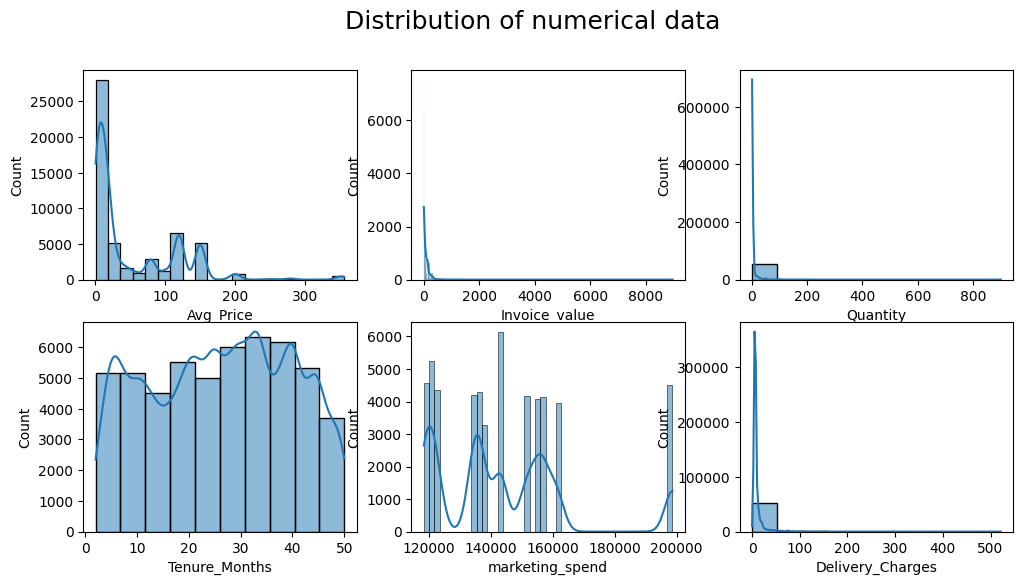

In [ ]:
plt.figure(figsize = (12,6))

plt.subplot(2,3,1)
sns.histplot(data=sales, x='Avg_Price', bins=20,kde=True)

plt.subplot(2,3,2)
sns.histplot(data=sales, x='Invoice_value',kde=True)

plt.subplot(2,3,3)
sns.histplot(data=sales, x='Quantity',bins=10, kde=True)

plt.subplot(2,3,4)
sns.histplot(data=sales, x='Tenure_Months',bins=10, kde=True)

plt.subplot(2,3,5)
sns.histplot(data=sales, x='marketing_spend', kde=True)

plt.subplot(2,3,6)
sns.histplot(data=sales, x='Delivery_Charges', bins=10, kde=True)

plt.suptitle("Distribution of numerical data", size = 18, fontweight = "medium")
plt.show()

**Observations**

1.   Avg_Price, Invoice_value, Quantity and Delivery_Charges follows Log-Normal distribution.
2.   Tenure_months observed to follow a uniform distribution
3. marketing_spend data shows a multi-modal distribution



/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:1608: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


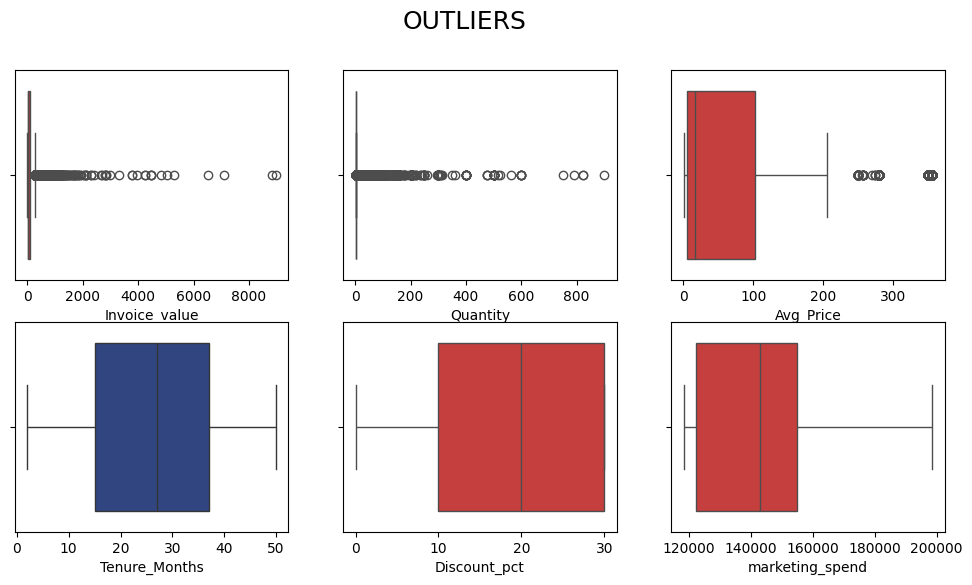

In [ ]:
# Checking outliers using boxplot

aero_blue = "#243e8d"
aero_grey = "#808080"
aero_red = "#db2926"

plt.figure(figsize = (12,6))

plt.subplot(2,3,1)
sns.boxplot(data = sales, x = "Invoice_value", orient = "v",color = aero_red)

plt.subplot(2,3,3)
sns.boxplot(data = sales, x = "Avg_Price", orient = "v",color = aero_red)

plt.subplot(2,3,2)
sns.boxplot(data = sales, x = "Quantity", orient = "v", color = aero_grey)

plt.subplot(2,3,4)
sns.boxplot(data = sales, x = "Tenure_Months", orient = "h", color = aero_blue)

plt.subplot(2,3,5)
sns.boxplot(data = sales, x = "Discount_pct", orient = "h", color = aero_red)

plt.subplot(2,3,6)
sns.boxplot(data = sales, x = "marketing_spend", orient = "h", color = aero_red)

plt.suptitle("OUTLIERS", size = 18, fontweight = "medium")
plt.show()

**Observations**

1.   avg_price, Invoice_value and Quantity observed to have large number of outliers on the right side. Which explains there are less frequent purchases with large quantity and  higher invoice_values
2.   The average tenure of customers engaging with the purchasing observed to be between 15 to 38 months
3. Most of the marketing revenue spent was observed to be between USD 120000 and USD 160000



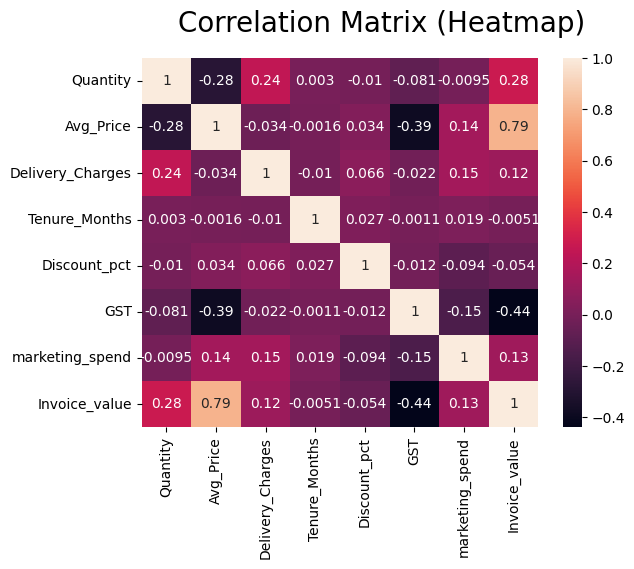

In [ ]:
sns.heatmap(sales.corr(numeric_only=True, method='spearman'), annot = True)

plt.suptitle("Correlation Matrix (Heatmap)", size = 20, fontweight = "medium")
plt.show()

**Observations**

1.   No significant positive correlations observed between marketing spend, Quantity, Discount percentages and price/Invoice values



<ipython-input-195-f69cf9eca18d>:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(data=sales, x='Location', hue='Gender', palette=colors)
<ipython-input-195-f69cf9eca18d>:13: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.countplot(data=sales, x='Discount_pct', hue='Gender', palette=colors)
<ipython-input-195-f69cf9eca18d>:17: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=sales, x='Gender', hue='Discount_pct', palette=colors)
<ipython-input-195-f69cf9eca18d>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sales, x='Month', palette=colors)
<ipython-input-195-f69cf9eca18d>:25: UserWarning: 
The palette list has fewe

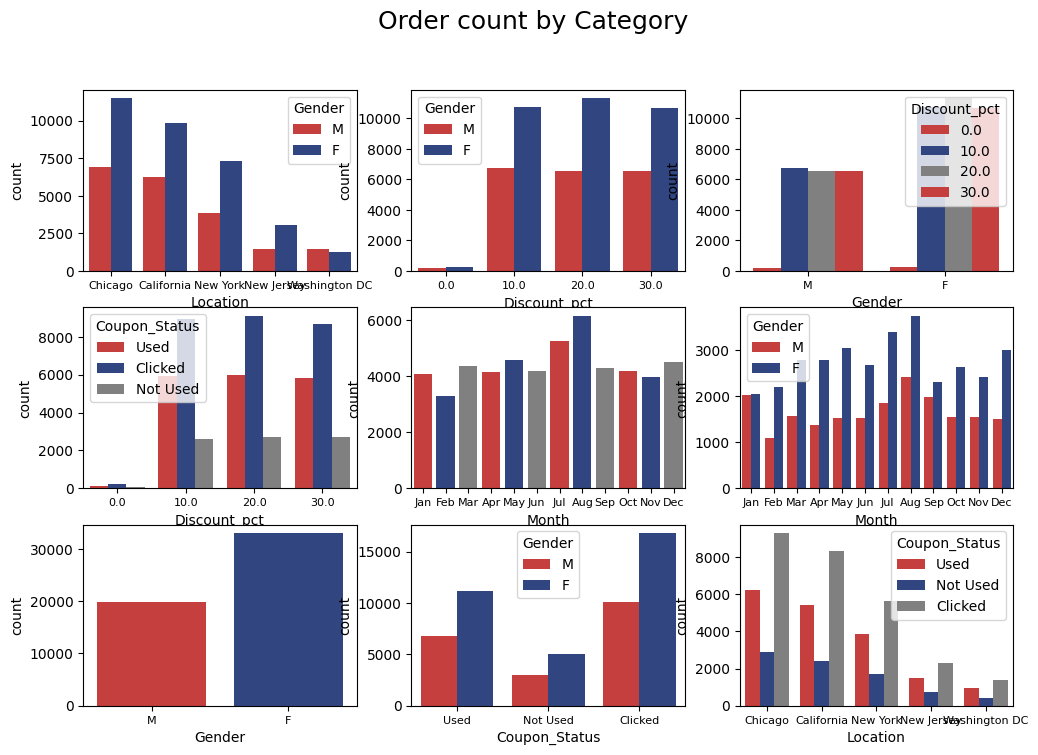

In [ ]:
plt.figure(figsize = (12,8))

aero_blue = "#243e8d"
aero_grey = "#808080"
aero_red = "#db2926"
colors = [aero_red, aero_blue, aero_grey]

plt.subplot(3,3,1)
sns.countplot(data=sales, x='Location', hue='Gender', palette=colors)
plt.xticks(fontsize=8)

plt.subplot(3,3,2)
sns.countplot(data=sales, x='Discount_pct', hue='Gender', palette=colors)
plt.xticks(fontsize=8)

plt.subplot(3,3,3)
sns.countplot(data=sales, x='Gender', hue='Discount_pct', palette=colors)
plt.xticks(fontsize=8)

plt.subplot(3,3,4)
sns.countplot(data=sales, x='Discount_pct', hue='Coupon_Status', palette=colors)
plt.xticks(fontsize=8)

plt.subplot(3,3,5)
sns.countplot(data=sales, x='Month', palette=colors)
plt.xticks(fontsize=8)

plt.subplot(3,3,6)
sns.countplot(data=sales, x='Month', hue='Gender', palette=colors)
plt.xticks(fontsize=8)

plt.subplot(3,3,7)
sns.countplot(data=sales, x='Gender', palette=colors)
plt.xticks(fontsize=8)

plt.subplot(3,3,8)
sns.countplot(data=sales, x='Coupon_Status', hue='Gender', palette=colors)
plt.xticks(fontsize=8)

plt.subplot(3,3,9)
sns.countplot(data=sales, x='Location', hue='Coupon_Status', palette=colors)
plt.xticks(fontsize=8)

plt.suptitle("Order count by Category", size = 18, fontweight = "medium")
plt.show()

**Observations**

1.   Most number of orders are placed from Chicago, California and New York regions having most number of customers who engaged with coupons
2.   Female customers tend to purchase more across Chicago, California and New York with most purchase done between the month of March and August



<ipython-input-196-43c874c95f2b>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales, x='Gender', y='Invoice_value', palette=colors)
<ipython-input-196-43c874c95f2b>:9: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(data=sales, x='Gender', y='Invoice_value', palette=colors)
<ipython-input-196-43c874c95f2b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales, x='Location', y='Invoice_value', palette=colors)
<ipython-input-196-43c874c95f2b>:13: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=sales, x='Location', y='Inv

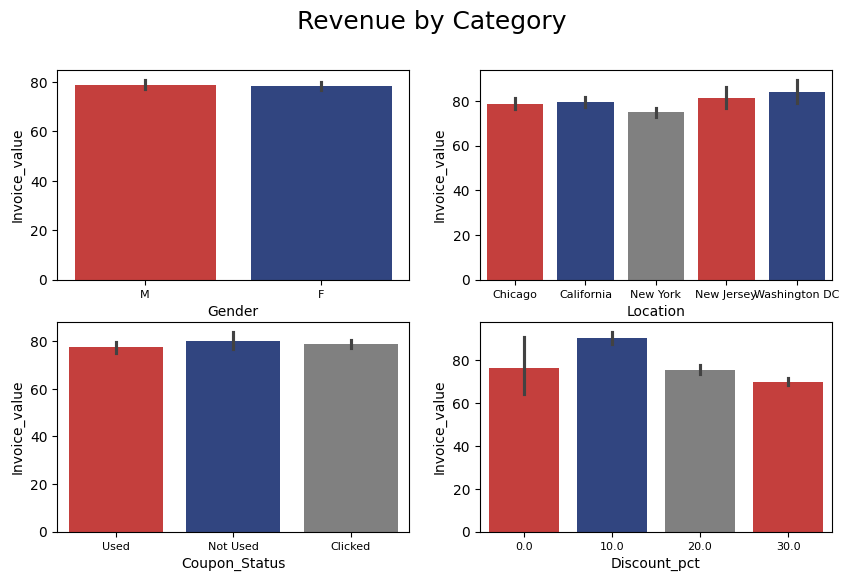

In [ ]:
plt.figure(figsize = (10,6))

aero_blue = "#243e8d"
aero_grey = "#808080"
aero_red = "#db2926"
colors = [aero_red, aero_blue, aero_grey]

plt.subplot(2,2,1)
sns.barplot(data=sales, x='Gender', y='Invoice_value', palette=colors)
plt.xticks(fontsize=8)

plt.subplot(2,2,2)
sns.barplot(data=sales, x='Location', y='Invoice_value', palette=colors)
plt.xticks(fontsize=8)

plt.subplot(2,2,3)
sns.barplot(data=sales, x='Coupon_Status', y='Invoice_value', palette=colors)
plt.xticks(fontsize=8)

plt.subplot(2,2,4)
sns.barplot(data=sales, x='Discount_pct', y='Invoice_value', palette=colors)
plt.xticks(fontsize=8)

plt.suptitle("Revenue by Category", size = 18, fontweight = "medium")
plt.show()

**Observations**

1.   There is no difference in the overall purchase value between male and female customers, Locations, and Coupon_status
2.   Discount of 10% is observed to contribute more revenue compared to 20% and 30% discount percentages



<Axes: title={'center': 'Top 5 Product Categories'}, xlabel='Product_Category', ylabel='count'>

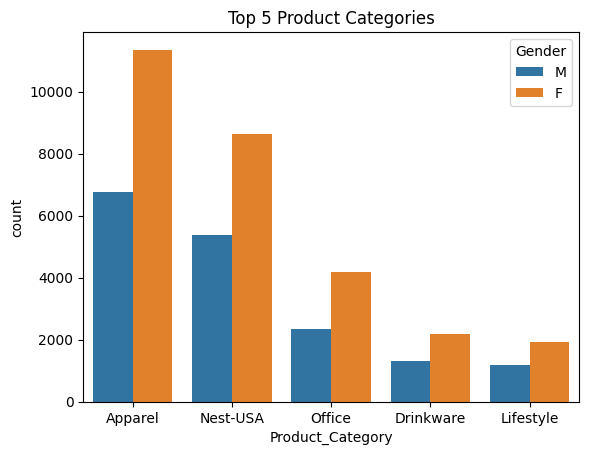

In [ ]:
top_category = sales['Product_Category'].value_counts(ascending=False)
plt.title('Top 5 Product Categories')
sns.countplot(data=sales, x='Product_Category', order = top_category.index[:5], hue='Gender')

<Axes: title={'center': 'Least Purchased Product Categories'}, xlabel='Product_Category', ylabel='count'>

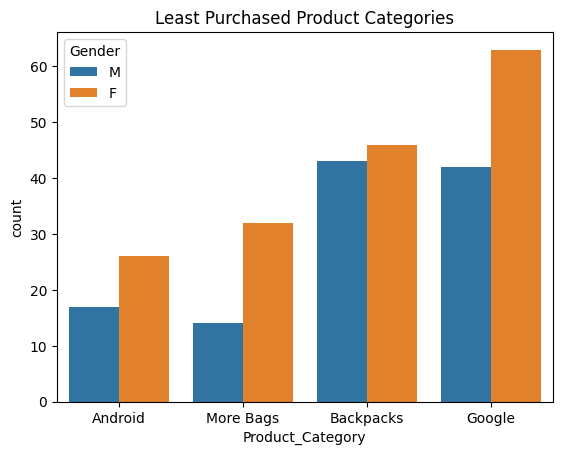

In [ ]:
plt.title('Least Purchased Product Categories')
sns.countplot(data=sales, x='Product_Category', order = top_category.index[-1:-5:-1], hue='Gender')

<Axes: title={'center': 'Top Coupon Codes Used'}, xlabel='Coupon_Code', ylabel='count'>

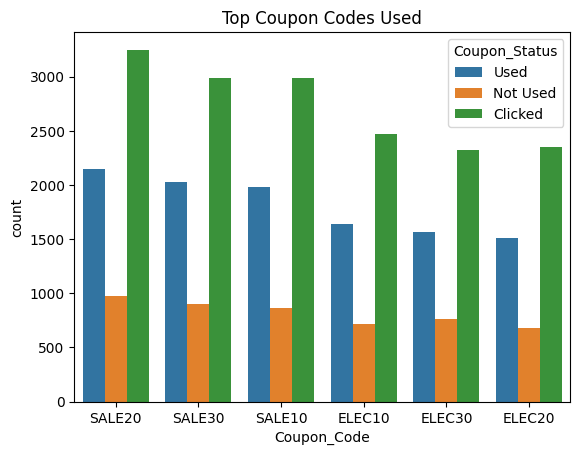

In [ ]:
top_coupons = sales['Coupon_Code'].value_counts(ascending=False)
plt.title('Top Coupon Codes Used')
sns.countplot(data=sales, x='Coupon_Code', order = top_coupons.index[:6], hue='Coupon_Status')

<Axes: title={'center': 'Coupon Codes Used by Gender'}, xlabel='Coupon_Code', ylabel='count'>

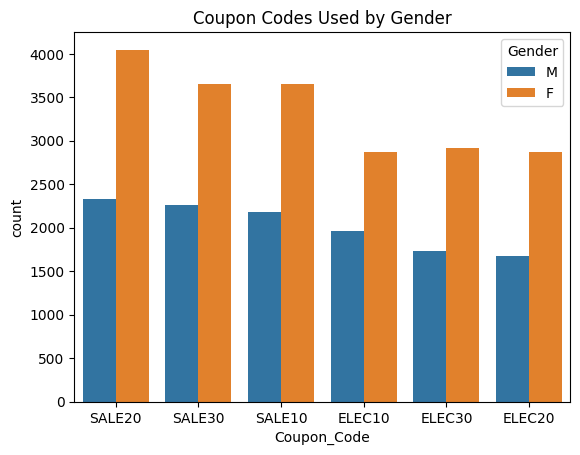

In [ ]:
plt.title('Coupon Codes Used by Gender')
sns.countplot(data=sales, x='Coupon_Code', order = top_coupons.index[:6], hue='Gender')

<Axes: title={'center': 'Least used Coupon Codes'}, xlabel='Coupon_Code', ylabel='count'>

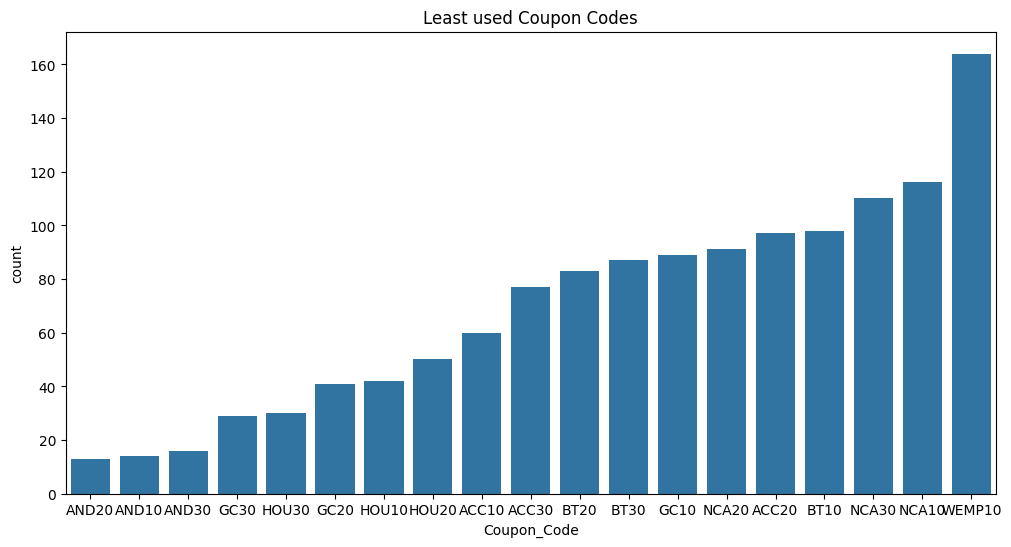

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Least used Coupon Codes')
sns.countplot(data=sales, x='Coupon_Code', order = top_coupons.index[-1:-20:-1])

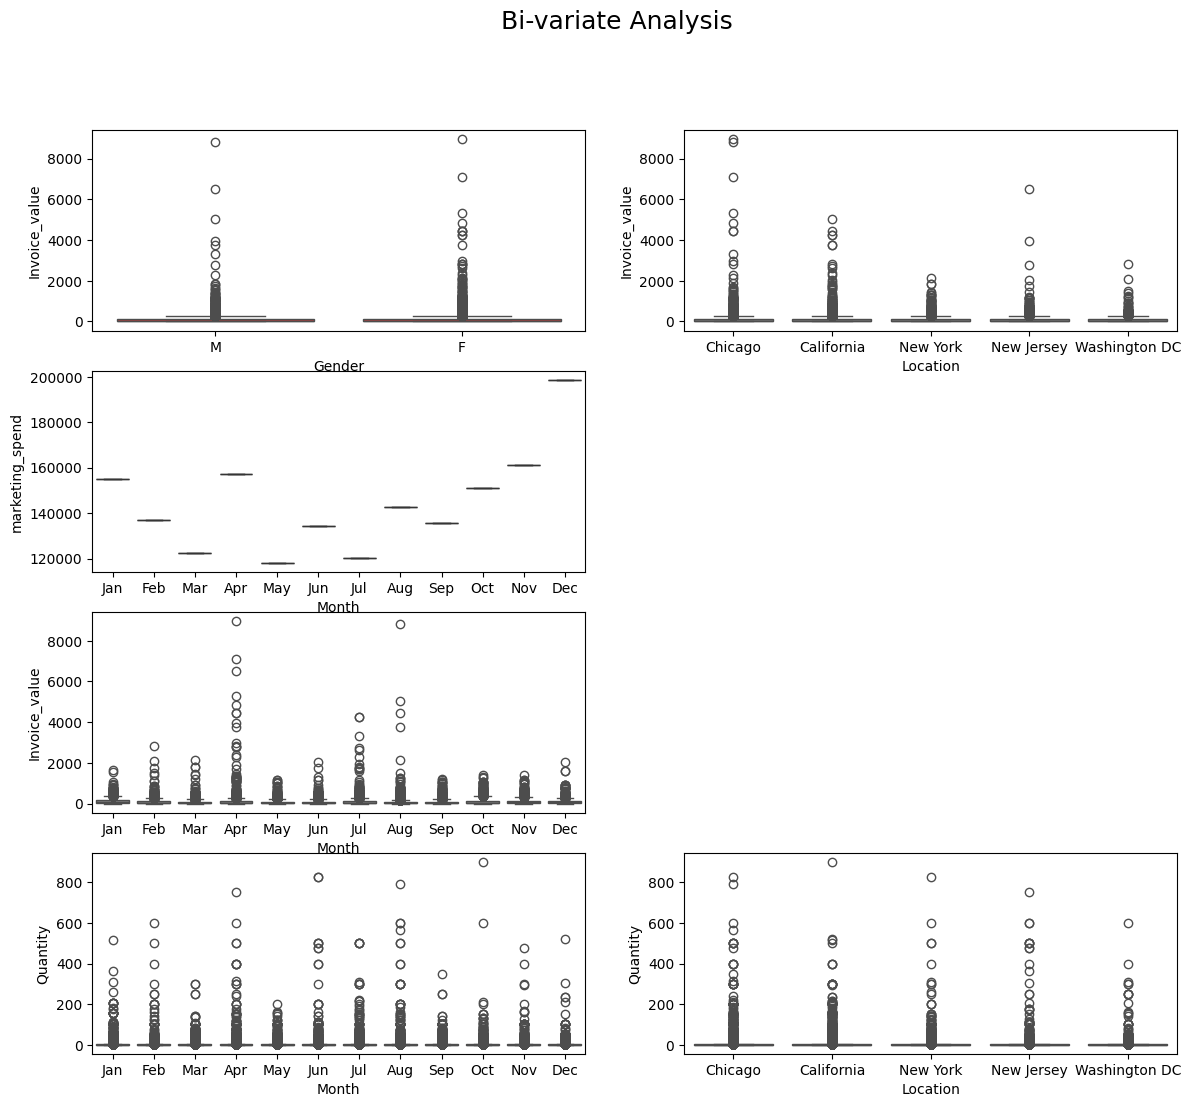

In [ ]:
aero_blue = "#243e8d"
aero_grey = "#808080"
aero_red = "#db2926"

plt.figure(figsize = (14,12))

plt.subplot(4,2,1)
sns.boxplot(data=sales, x='Gender', y='Invoice_value', color = aero_red)

plt.subplot(4,2,2)
sns.boxplot(data=sales, x='Location', y='Invoice_value', color = aero_grey)

plt.subplot(4,2,3)
sns.boxplot(data=sales, x='Month', y='marketing_spend', color = aero_blue)

plt.subplot(4,2,5)
sns.boxplot(data=sales, x='Month', y='Invoice_value', color = aero_grey)

plt.subplot(4,2,7)
sns.boxplot(data=sales, x='Month', y='Quantity', color = aero_red)

plt.subplot(4,2,8)
sns.boxplot(data=sales, x='Location', y='Quantity', color = aero_red)


plt.suptitle("Bi-variate Analysis", size = 18, fontweight = "medium")
plt.show()

**Observations**

1.   Invoive values, marketing spend and Quantity observed to show significant outliers across Month, Gender and Locations



### **Basic Metrics Analysis (KPIs)**

In [ ]:
# Average Order Value
aov = sales['Invoice_value'].sum() / sales['Transaction_ID'].nunique()
print(f'Average Order Value : ${round(aov,2)}')

Average Order Value : $165.91


In [ ]:
# Average order value across different Discount percentages

aov_0 = sales[sales['Discount_pct']==0.0]['Invoice_value'].sum() / sales[sales['Discount_pct']==0.0]['CustomerID'].nunique()
aov_10 = sales[sales['Discount_pct']==10.0]['Invoice_value'].sum() / sales[sales['Discount_pct']==10.0]['CustomerID'].nunique()
aov_20 = sales[sales['Discount_pct']==20.0]['Invoice_value'].sum() / sales[sales['Discount_pct']==20.0]['CustomerID'].nunique()
aov_30 = sales[sales['Discount_pct']==30.0]['Invoice_value'].sum() / sales[sales['Discount_pct']==30.0]['CustomerID'].nunique()

print(f'Average Order Value at 0% discount  : ${round(aov_0,2)}')
print(f'Average Order Value at 10% discount : ${round(aov_10,2)}')
print(f'Average Order Value at 20% discount : ${round(aov_20,2)}')
print(f'Average Order Value at 30% discount : ${round(aov_30,2)}')

Average Order Value at 0% discount  : $119.08
Average Order Value at 10% discount : $2176.0
Average Order Value at 20% discount : $2066.05
Average Order Value at 30% discount : $1642.9


In [ ]:
# Customer Value = AOV * AOFR
customer_value = aov * aofr
print(f'Customer Value : ${round(customer_value,2)}')

Customer Value : $2832.34


In [ ]:
# Average Customer Lifespan

customer_lifespan = sales.groupby('CustomerID')['Transaction_Date'].agg(['min', 'max']).reset_index()
customer_lifespan.columns = ['CustomerID', 'first_purchase_date', 'last_purchase_date']

customer_lifespan['lifespan'] = (customer_lifespan['last_purchase_date'] - customer_lifespan['first_purchase_date']).dt.days
acl = customer_lifespan['lifespan'].mean() / 365
print(f'Average Customer Lifespan : {round(acl,2)}')

Average Customer Lifespan : 0.18


In [ ]:
# Customer Life Time Value (LTV) = Customer Value * Avg. Customer Lifespan

ltv = customer_value * acl
print(f'Customer Life Time Value : ${round(ltv,2)}')

Customer Life Time Value : $499.42


In [ ]:
# Customer Acquisition cost --> Total marketing spend / Total number of new customers
# Calculating the count of New customers per month from first purchase date

first_purchase = sales.groupby('CustomerID')['Transaction_Date'].min().reset_index()
first_purchase.rename(columns={'Transaction_Date': 'First_Purchase_Date'}, inplace=True)
first_purchase.head()

,CustomerID,First_Purchase_Date
0,12346,2019-09-15
1,12347,2019-03-24
2,12348,2019-06-22
3,12350,2019-12-14
4,12356,2019-09-15


In [ ]:
first_purchase['month'] = first_purchase['First_Purchase_Date'].dt.to_period('M')
new_customers_per_month = first_purchase.groupby('month')['CustomerID'].nunique().reset_index()
new_customers_per_month.head()

,month,CustomerID
0,2019-01,215
1,2019-02,96
2,2019-03,177
3,2019-04,163
4,2019-05,112


In [ ]:
# Customer Acquisition Cost

cac = marketing_spend['marketing_spend'].sum() / new_customers_per_month['CustomerID'].sum()
print(f'Customer Acquisition Cost : ${round(cac,2)}')

Customer Acquisition Cost : $1180.89


In [ ]:
# CAC to LTV Ratio --> Ideally, your CAC should be about one-third or less of your LTV
# Common Benchmark --> LTV / CAC >= 3

cac_ltv_ratio = ltv / cac
print(f'CAC to LTV Ratio : {round(cac_ltv_ratio,2)}')

CAC to LTV Ratio : 0.42


### **Cohort Analysis**

In [ ]:
first_purchase['cohort'] = first_purchase['First_Purchase_Date'].dt.to_period('M')
sales['purchase_month'] = sales['Transaction_Date'].dt.to_period('M')

sales = pd.merge(sales, first_purchase[['CustomerID','cohort']], on='CustomerID')

In [ ]:
cohort_data = sales.groupby(['cohort', 'purchase_month']).agg(
    Customers = ('CustomerID', 'nunique'),
    Orders = ('Transaction_ID', 'count'),
    Revenue = ('Invoice_value', 'sum')
).reset_index()
cohort_data

,cohort,purchase_month,Customers,Orders,Revenue
0,2019-01,2019-01,215,4063,404640.73705
1,2019-01,2019-02,13,437,35012.22768
2,2019-01,2019-03,24,620,37201.79533
3,2019-01,2019-04,34,768,116014.30099
4,2019-01,2019-05,23,450,26115.65248
...,...,...,...,...,...
73,2019-10,2019-11,6,56,8416.28840
74,2019-10,2019-12,4,27,2105.46455
75,2019-11,2019-11,68,1787,189722.84568
76,2019-11,2019-12,7,33,3404.58111


In [ ]:
cohort_data['cohort_month'] = (cohort_data['purchase_month'] - cohort_data['cohort']).apply(lambda x: x.n)
cohort_data

,cohort,purchase_month,Customers,Orders,Revenue,cohort_month
0,2019-01,2019-01,215,4063,404640.73705,0
1,2019-01,2019-02,13,437,35012.22768,1
2,2019-01,2019-03,24,620,37201.79533,2
3,2019-01,2019-04,34,768,116014.30099,3
4,2019-01,2019-05,23,450,26115.65248,4
...,...,...,...,...,...,...
73,2019-10,2019-11,6,56,8416.28840,1
74,2019-10,2019-12,4,27,2105.46455,2
75,2019-11,2019-11,68,1787,189722.84568,0
76,2019-11,2019-12,7,33,3404.58111,1


In [ ]:
cohort_pivot1 = cohort_data.pivot_table(
    index='cohort', columns='cohort_month', values=['Customers']
)
cohort_pivot1

Customers                                                        \
cohort_month        0     1     2     3     4     5     6     7     8     9    
cohort                                                                         
2019-01          215.0  13.0  24.0  34.0  23.0  44.0  35.0  47.0  23.0  28.0   
2019-02           96.0   7.0   9.0  16.0  17.0  22.0  19.0  15.0  12.0  11.0   
2019-03          177.0  18.0  35.0  25.0  32.0  33.0  22.0  22.0  15.0  19.0   
2019-04          163.0  14.0  24.0  24.0  18.0  15.0  10.0  16.0  12.0   NaN   
2019-05          112.0  12.0   9.0  13.0  10.0  13.0  14.0   8.0   NaN   NaN   
2019-06          137.0  20.0  22.0  12.0  11.0  14.0  11.0   NaN   NaN   NaN   
2019-07           94.0  13.0   4.0   6.0  11.0   9.0   NaN   NaN   NaN   NaN   
2019-08          135.0  14.0  15.0  10.0   8.0   NaN   NaN   NaN   NaN   NaN   
2019-09           78.0   6.0   3.0   2.0   NaN   NaN   NaN   NaN   NaN   NaN   
2019-10           87.0   6.0   4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2019-11           68.0   7.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2019-12          106.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                          
cohort_month    10    11  
cohort                    
2019-01       20.0  34.0  
2019-02       16.0   NaN  
2019-03        NaN   NaN  
2019-04        NaN   NaN  
2019-05        NaN   NaN  
2019-06        NaN   NaN  
2019-07        NaN   NaN  
2019-08        NaN   NaN  
2019-09        NaN   NaN  
2019-10        NaN   NaN  
2019-11        NaN   NaN  
2019-12        NaN   NaN

In [ ]:
cohort_pivot2 = cohort_data.pivot_table(
    index='cohort', columns='cohort_month', values=['Orders']
)
cohort_pivot2

Orders                                                           \
cohort_month      0      1      2      3      4      5       6      7      8    
cohort                                                                          
2019-01       4063.0  437.0  620.0  768.0  450.0  767.0  1021.0  749.0  525.0   
2019-02       2847.0  143.0  160.0  360.0  319.0  691.0   387.0  523.0  175.0   
2019-03       3583.0  372.0  509.0  334.0  594.0  806.0   555.0  342.0  241.0   
2019-04       2850.0  233.0  222.0  431.0  316.0  285.0   142.0  370.0  166.0   
2019-05       3020.0   90.0  187.0  280.0  164.0  428.0   257.0  113.0    NaN   
2019-06       2461.0  226.0  215.0  214.0  148.0  332.0   158.0    NaN    NaN   
2019-07       2101.0  242.0   90.0  176.0  146.0  229.0     NaN    NaN    NaN   
2019-08       3155.0   90.0  119.0  213.0  114.0    NaN     NaN    NaN    NaN   
2019-09       1842.0   19.0   26.0    6.0    NaN    NaN     NaN    NaN    NaN   
2019-10       2143.0   56.0   27.0    NaN    NaN    NaN     NaN    NaN    NaN   
2019-11       1787.0   33.0    NaN    NaN    NaN    NaN     NaN    NaN    NaN   
2019-12       2181.0    NaN    NaN    NaN    NaN    NaN     NaN    NaN    NaN   

                                   
cohort_month     9      10     11  
cohort                             
2019-01       472.0  317.0  749.0  
2019-02       216.0  393.0    NaN  
2019-03       333.0    NaN    NaN  
2019-04         NaN    NaN    NaN  
2019-05         NaN    NaN    NaN  
2019-06         NaN    NaN    NaN  
2019-07         NaN    NaN    NaN  
2019-08         NaN    NaN    NaN  
2019-09         NaN    NaN    NaN  
2019-10         NaN    NaN    NaN  
2019-11         NaN    NaN    NaN  
2019-12         NaN    NaN    NaN

In [ ]:
cohort_pivot3 = cohort_data.pivot_table(
    index='cohort', columns='cohort_month', values=['Revenue']
)
cohort_pivot3

Revenue                                          \
cohort_month            0            1            2             3    
cohort                                                               
2019-01       404640.73705  35012.22768  37201.79533  116014.30099   
2019-02       243667.73252   6427.06319  12789.26894   19901.90572   
2019-03       232376.40531  41329.21303  32685.00656   24074.97013   
2019-04       236384.67227  20937.78912  13053.19791   29799.81371   
2019-05       177519.77668   5360.82274  11958.23849   12591.94768   
2019-06       151090.12360  10565.30240  11361.89248   11923.97735   
2019-07       151017.18783  13176.14284   5596.66539   14477.13351   
2019-08       171218.55900   8170.34778  10977.43536   25138.79760   
2019-09       114115.61815   1916.60076   2218.10240     497.01589   
2019-10       214982.89234   8416.28840   2105.46455           NaN   
2019-11       189722.84568   3404.58111          NaN           NaN   
2019-12       189754.48961          NaN          NaN           NaN   

                                                                               \
cohort_month           4            5            6            7            8    
cohort                                                                          
2019-01       26115.65248  40370.77256  83958.67305  44517.31180  31267.35229   
2019-02       18366.86237  41616.49010  19989.08248  34915.04513  16972.00965   
2019-03       46342.70803  62012.19732  37533.93581  39248.64297  21577.93368   
2019-04       22193.86344  23352.12824  15466.70412  49415.12632  13895.31444   
2019-05       13247.86624  35561.06964  33171.89872   8765.61413          NaN   
2019-06        9973.52640  32161.82928  11837.62972          NaN          NaN   
2019-07       21141.90628  22235.61249          NaN          NaN          NaN   
2019-08       12752.55058          NaN          NaN          NaN          NaN   
2019-09               NaN          NaN          NaN          NaN          NaN   
2019-10               NaN          NaN          NaN          NaN          NaN   
2019-11               NaN          NaN          NaN          NaN          NaN   
2019-12               NaN          NaN          NaN          NaN          NaN   

                                                    
cohort_month           9            10          11  
cohort                                              
2019-01       45299.56780  35461.68740  71919.9971  
2019-02       25163.80760  36527.30662         NaN  
2019-03       27952.46391          NaN         NaN  
2019-04               NaN          NaN         NaN  
2019-05               NaN          NaN         NaN  
2019-06               NaN          NaN         NaN  
2019-07               NaN          NaN         NaN  
2019-08               NaN          NaN         NaN  
2019-09               NaN          NaN         NaN  
2019-10               NaN          NaN         NaN  
2019-11               NaN          NaN         NaN  
2019-12               NaN          NaN         NaN

In [ ]:
# Customer Cohort Retention Rate

Customer_cohort_sizes = cohort_pivot1.iloc[:, 0]
Customer_retention_rate = cohort_pivot1.divide(Customer_cohort_sizes, axis=0)*100
Customer_retention_rate

Customers                                                         \
cohort_month        0          1          2          3          4          5    
cohort                                                                          
2019-01          100.0   6.046512  11.162791  15.813953  10.697674  20.465116   
2019-02          100.0   7.291667   9.375000  16.666667  17.708333  22.916667   
2019-03          100.0  10.169492  19.774011  14.124294  18.079096  18.644068   
2019-04          100.0   8.588957  14.723926  14.723926  11.042945   9.202454   
2019-05          100.0  10.714286   8.035714  11.607143   8.928571  11.607143   
2019-06          100.0  14.598540  16.058394   8.759124   8.029197  10.218978   
2019-07          100.0  13.829787   4.255319   6.382979  11.702128   9.574468   
2019-08          100.0  10.370370  11.111111   7.407407   5.925926        NaN   
2019-09          100.0   7.692308   3.846154   2.564103        NaN        NaN   
2019-10          100.0   6.896552   4.597701        NaN        NaN        NaN   
2019-11          100.0  10.294118        NaN        NaN        NaN        NaN   
2019-12          100.0        NaN        NaN        NaN        NaN        NaN   

                                                                                
cohort_month         6          7          8          9          10         11  
cohort                                                                          
2019-01       16.279070  21.860465  10.697674  13.023256   9.302326  15.813953  
2019-02       19.791667  15.625000  12.500000  11.458333  16.666667        NaN  
2019-03       12.429379  12.429379   8.474576  10.734463        NaN        NaN  
2019-04        6.134969   9.815951   7.361963        NaN        NaN        NaN  
2019-05       12.500000   7.142857        NaN        NaN        NaN        NaN  
2019-06        8.029197        NaN        NaN        NaN        NaN        NaN  
2019-07             NaN        NaN        NaN        NaN        NaN        NaN  
2019-08             NaN        NaN        NaN        NaN        NaN        NaN  
2019-09             NaN        NaN        NaN        NaN        NaN        NaN  
2019-10             NaN        NaN        NaN        NaN        NaN        NaN  
2019-11             NaN        NaN        NaN        NaN        NaN        NaN  
2019-12             NaN        NaN        NaN        NaN        NaN        NaN

In [ ]:
# Orders Cohort Retention Rate

Orders_cohort_sizes = cohort_pivot2.iloc[:, 0]
Orders_retention_rate = cohort_pivot2.divide(Orders_cohort_sizes, axis=0)*100
Orders_retention_rate

Orders                                                         \
cohort_month     0          1          2          3          4          5    
cohort                                                                       
2019-01       100.0  10.755599  15.259660  18.902289  11.075560  18.877677   
2019-02       100.0   5.022831   5.619951  12.644889  11.204777  24.271163   
2019-03       100.0  10.382361  14.205973   9.321797  16.578286  22.495116   
2019-04       100.0   8.175439   7.789474  15.122807  11.087719  10.000000   
2019-05       100.0   2.980132   6.192053   9.271523   5.430464  14.172185   
2019-06       100.0   9.183259   8.736286   8.695652   6.013816  13.490451   
2019-07       100.0  11.518325   4.283674   8.376963   6.949072  10.899572   
2019-08       100.0   2.852615   3.771791   6.751189   3.613312        NaN   
2019-09       100.0   1.031488   1.411509   0.325733        NaN        NaN   
2019-10       100.0   2.613159   1.259916        NaN        NaN        NaN   
2019-11       100.0   1.846670        NaN        NaN        NaN        NaN   
2019-12       100.0        NaN        NaN        NaN        NaN        NaN   

                                                                                
cohort_month         6          7          8          9          10         11  
cohort                                                                          
2019-01       25.129215  18.434654  12.921487  11.617032   7.802117  18.434654  
2019-02       13.593256  18.370214   6.146821   7.586934  13.804004        NaN  
2019-03       15.489813   9.545074   6.726207   9.293888        NaN        NaN  
2019-04        4.982456  12.982456   5.824561        NaN        NaN        NaN  
2019-05        8.509934   3.741722        NaN        NaN        NaN        NaN  
2019-06        6.420154        NaN        NaN        NaN        NaN        NaN  
2019-07             NaN        NaN        NaN        NaN        NaN        NaN  
2019-08             NaN        NaN        NaN        NaN        NaN        NaN  
2019-09             NaN        NaN        NaN        NaN        NaN        NaN  
2019-10             NaN        NaN        NaN        NaN        NaN        NaN  
2019-11             NaN        NaN        NaN        NaN        NaN        NaN  
2019-12             NaN        NaN        NaN        NaN        NaN        NaN

In [ ]:
# Revenue Cohort Retention Rate

Revenue_cohort_sizes = cohort_pivot3.iloc[:, 0]
Revenue_retention_rate = cohort_pivot3.divide(Revenue_cohort_sizes, axis=0)*100
Revenue_retention_rate

Revenue                                                         \
cohort_month      0          1          2          3          4          5    
cohort                                                                        
2019-01        100.0   8.652670   9.193784  28.670940   6.454034   9.976942   
2019-02        100.0   2.637634   5.248651   8.167641   7.537667  17.079196   
2019-03        100.0  17.785460  14.065544  10.360333  19.942949  26.686099   
2019-04        100.0   8.857507   5.522015  12.606492   9.388876   9.878867   
2019-05        100.0   3.019845   6.736285   7.093265   7.462755  20.032173   
2019-06        100.0   6.992715   7.519944   7.891963   6.601045  21.286520   
2019-07        100.0   8.724929   3.705979   9.586414  13.999669  14.723895   
2019-08        100.0   4.771882   6.411358  14.682285   7.448112        NaN   
2019-09        100.0   1.679525   1.943733   0.435537        NaN        NaN   
2019-10        100.0   3.914864   0.979364        NaN        NaN        NaN   
2019-11        100.0   1.794502        NaN        NaN        NaN        NaN   
2019-12        100.0        NaN        NaN        NaN        NaN        NaN   

                                                                               
cohort_month         6          7         8          9          10         11  
cohort                                                                         
2019-01       20.748942  11.001688  7.727188  11.195009   8.763746  17.773791  
2019-02        8.203418  14.328957  6.965227  10.327099  14.990621        NaN  
2019-03       16.152215  16.890115  9.285768  12.028960        NaN        NaN  
2019-04        6.543023  20.904539  5.878264        NaN        NaN        NaN  
2019-05       18.686312   4.937824       NaN        NaN        NaN        NaN  
2019-06        7.834814        NaN       NaN        NaN        NaN        NaN  
2019-07             NaN        NaN       NaN        NaN        NaN        NaN  
2019-08             NaN        NaN       NaN        NaN        NaN        NaN  
2019-09             NaN        NaN       NaN        NaN        NaN        NaN  
2019-10             NaN        NaN       NaN        NaN        NaN        NaN  
2019-11             NaN        NaN       NaN        NaN        NaN        NaN  
2019-12             NaN        NaN       NaN        NaN        NaN        NaN

**Observations**

1.   As we observe the cohort sizes, we see there is inconsistancy in the acquisition of new customers / new orders / increase in revenue each month
2. The Customer retention rates for all the cohorts majorly lie between 9% and 20%. January, Febuary and March Cohorts observed to have better retention rates compared to other months
2.   The order retention rates for January and March months were better compared to other months which are between 10% and 20% on an average
3. The revenue retention rates for January and March months were better compared to other months which are between 10% and 20% on an average
4. Overall, January and March month Cohorts have better retention rate (however less than the ideal requirement)



### **RFM Analysis**

In [ ]:
# Calculate frequency (number of transactions) for each customer
frequency = sales.groupby('CustomerID')['Transaction_ID'].nunique().reset_index()
frequency.rename(columns={'Transaction_ID': 'Frequency'}, inplace=True)
frequency.head()

,CustomerID,Frequency
0,12346,1
1,12347,31
2,12348,8
3,12350,11
4,12356,13


In [ ]:
monetary = sales.groupby('CustomerID')['Invoice_value'].sum().reset_index()
monetary.rename(columns={'Invoice_value': 'Monetary'}, inplace=True)
monetary.head()

,CustomerID,Monetary
0,12346,24.98174
1,12347,11425.15580
2,12348,1304.77620
3,12350,1055.83394
4,12356,1115.96086


In [ ]:
recency = sales.groupby('CustomerID')['Transaction_Date'].max().reset_index()
recency.rename(columns={'Transaction_Date': 'Last_Purchase_Date'}, inplace=True)
recency['Recency'] = (recency['Last_Purchase_Date'].max() - recency['Last_Purchase_Date']).dt.days
recency.head()

,CustomerID,Last_Purchase_Date,Recency
0,12346,2019-09-15,107
1,12347,2019-11-02,59
2,12348,2019-10-19,73
3,12350,2019-12-14,17
4,12356,2019-09-15,107


In [ ]:
rfm = pd.merge(frequency, monetary, on='CustomerID')
rfm = pd.merge(rfm, recency.drop_duplicates(), on='CustomerID')
rfm.drop('Last_Purchase_Date', axis=1, inplace=True)
rfm.head()

,CustomerID,Frequency,Monetary,Recency
0,12346,1,24.98174,107
1,12347,31,11425.15580,59
2,12348,8,1304.77620,73
3,12350,11,1055.83394,17
4,12356,13,1115.96086,107


In [ ]:
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles

,CustomerID,Frequency,Monetary,Recency
0.25,13830.50,5.0,568.407542,55.0
0.50,15300.00,11.0,1567.683615,131.0
0.75,16882.25,23.0,3506.883418,220.0


In [ ]:
def r_score(x):
    if x <= quantiles['Recency'][0.25]:
        return 4
    elif x <= quantiles['Recency'][0.5]:
        return 3
    elif x <= quantiles['Recency'][0.75]:
        return 2
    else:
        return 1
def f_score(x):
    if x <= quantiles['Frequency'][0.25]:
        return 4
    elif x <= quantiles['Frequency'][0.5]:
        return 3
    elif x <= quantiles['Frequency'][0.75]:
        return 2
    else:
        return 1
def m_score(x):
    if x <= quantiles['Monetary'][0.25]:
        return 4
    elif x <= quantiles['Monetary'][0.5]:
        return 3
    elif x <= quantiles['Monetary'][0.75]:
        return 2
    else:
        return 1

rfm['R'] = rfm['Recency'].apply(r_score)
rfm['F'] = rfm['Frequency'].apply(f_score)
rfm['M'] = rfm['Monetary'].apply(m_score)

In [ ]:
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm

,CustomerID,Frequency,Monetary,Recency,R,F,M,RFM_Score
0,12346,1,24.98174,107,3,4,4,344
1,12347,31,11425.15580,59,3,1,1,311
2,12348,8,1304.77620,73,3,3,3,333
3,12350,11,1055.83394,17,4,3,3,433
4,12356,13,1115.96086,107,3,2,3,323
...,...,...,...,...,...,...,...,...
1463,18259,3,538.07980,270,1,4,4,144
1464,18260,19,2014.82033,87,3,2,2,322
1465,18269,2,104.16092,194,2,4,4,244
1466,18277,1,295.02000,69,3,4,4,344


In [ ]:
seg_map = {
    r'[1-2][1-2][1-5]': 'lost',
    r'[1-2][3-4][3-4]': 'at_Risk',
    r'[1-2][4-5][3-5]': 'cant_loose',
    r'[1-3][1-3][2-5]': 'need_attention',
    r'[3-4][4-5][1-5]': 'loyal_customers',
    r'5[4-5][4-5]': 'champions',
    r'4[2-5][2-5]': 'promising',
    r'[3-5][1-2][1-2]': 'new_customers',
    r'[1-2][3-4][1-5]': 'hibernating'
}
rfm['RFM_Segment'] = rfm['RFM_Score'].replace(seg_map, regex=True)
rfm.head()

,CustomerID,Frequency,Monetary,Recency,R,F,M,RFM_Score,RFM_Segment
0,12346,1,24.98174,107,3,4,4,344,loyal_customers
1,12347,31,11425.15580,59,3,1,1,311,new_customers
2,12348,8,1304.77620,73,3,3,3,333,need_attention
3,12350,11,1055.83394,17,4,3,3,433,promising
4,12356,13,1115.96086,107,3,2,3,323,need_attention


In [ ]:
rfm[["RFM_Segment", "Recency", "Frequency", "Monetary"]].groupby("RFM_Segment").agg(["mean", "count","max"])

Recency             Frequency                Monetary  \
                       mean count  max       mean count  max         mean   
RFM_Segment                                                                 
at_Risk          232.158654   416  364   4.579327   416   11   542.565426   
hibernating      267.166667     6  360   4.166667     6    5  3287.941275   
lost             226.111940   268  363  25.861940   268  177  3904.771090   
loyal_customers   68.875862   145  131   2.875862   145    5   424.919352   
need_attention   120.943396   212  363  12.735849   212   33  1773.419617   
new_customers     51.156489   262  130  48.240458   262  328  8167.342636   
promising         25.232704   159   54  12.666667   159   23  1814.722874   

                                    
                count          max  
RFM_Segment                         
at_Risk           416   1561.34384  
hibernating         6   6819.53292  
lost              268  34684.67341  
loyal_customers   145   2195.19354  
need_attention    212   3479.13864  
new_customers     262  71702.78430  
promising         159   3444.33167

**Observations**

1.   Considering loyal_customers and promising as active customers, ~300 customers are actively purchasing by placing ~2200 orders in a span of every ~50 days inducing an average revenue of USD 330000
2.   More than ~720 customers are under need_attention, at_Risk and hibernate segments who are not engaged enough to continue to purchase
3. There are ~262 new customers added between January and December months



### **Churn Analysis**

In [ ]:
# Churn Rate --> Considering 'lost' & 'at_Risk' segments as churned customers
churn_rate = round(((rfm[rfm['RFM_Segment']=='lost'].shape[0]) / rfm.shape[0])* 100,2)
print("Total customers churned :",rfm[rfm['RFM_Segment']=='lost'].shape[0])
print(f'Total customers : {rfm.shape[0]}')
print(f'Customer Churn Rate = {churn_rate}%')

Total customers churned : 268
Total customers : 1468
Customer Churn Rate = 18.26%


In [ ]:
sales = sales.merge(rfm[['CustomerID','RFM_Segment']], on='CustomerID', how='left')

In [ ]:
# Number of churned customers by month
sales[sales['RFM_Segment']=='lost'].groupby('Month')['CustomerID'].nunique()

Month
Apr    57
Aug    47
Feb    37
Jan    57
Jul    54
Jun    59
Mar    52
May    59
Name: CustomerID, dtype: int64

<ipython-input-210-5c8722dca68f>:13: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.countplot(data=churned_customers, x='Month', hue='RFM_Segment', palette=colors)
<ipython-input-210-5c8722dca68f>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=churned_customers, x='Product_Category', order=churn_by_product_category.index[:5], palette=colors)
<ipython-input-210-5c8722dca68f>:17: UserWarning: 
The palette list has fewer values (3) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(data=churned_customers, x='Product_Category', order=churn_by_product_category.index[:5], palette=colors)
<ipython-input-210-5c8722dca68f>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` 

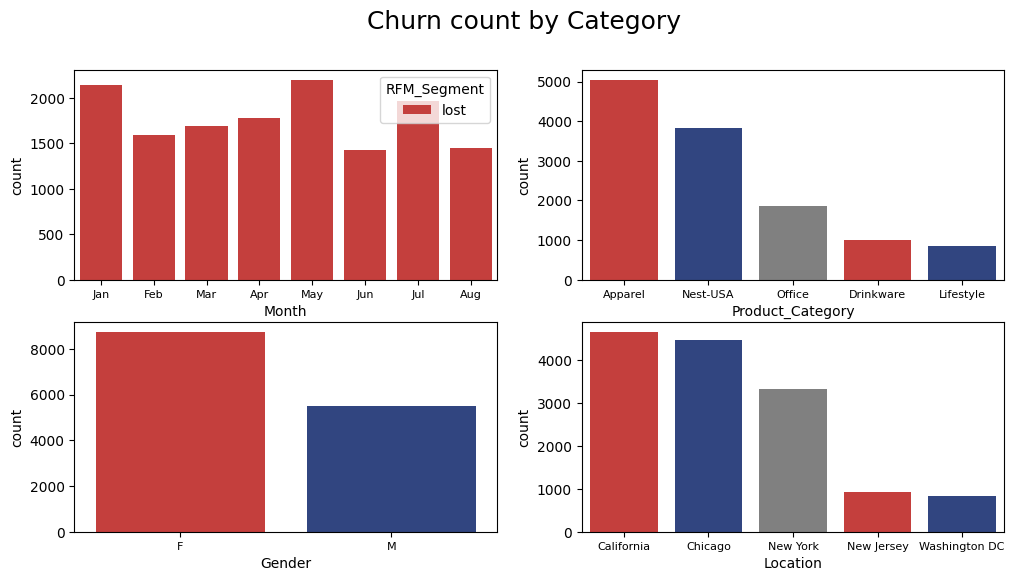

In [ ]:
# Churn analysis by Month, Product Categoty, Gender & Location

churned_customers = sales[sales['RFM_Segment']=='lost']

churn_by_product_category = churned_customers['Product_Category'].value_counts(ascending=False)
churn_by_gender = churned_customers['Gender'].value_counts(ascending=False)
churn_by_location = churned_customers['Location'].value_counts(ascending=False)

colors = [aero_red, aero_blue, aero_grey]
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
sns.countplot(data=churned_customers, x='Month', hue='RFM_Segment', palette=colors)
plt.xticks(fontsize=8)

plt.subplot(2,2,2)
sns.countplot(data=churned_customers, x='Product_Category', order=churn_by_product_category.index[:5], palette=colors)
plt.xticks(fontsize=8)

plt.subplot(2,2,3)
sns.countplot(data=churned_customers, x='Gender', order=churn_by_gender.index, palette=colors)
plt.xticks(fontsize=8)

plt.subplot(2,2,4)
sns.countplot(data=churned_customers, x='Location', order=churn_by_location.index, palette=colors)
plt.xticks(fontsize=8)

plt.suptitle("Churn count by Category", size = 18, fontweight = "medium")
plt.show()

**Observations**

1.   The Customer Churn rate is at 18.26%
2.   Female customers tend to churn more than male customers
3. California, Chicago and New York regions observed to have more churn rates
4. As observed, customers purchasing product categories - Apparel and Nest-USA have churned more with no further purchases



### **Market Basket Analysis (Using One-hot Encoding)**

In [ ]:
basket = sales.groupby(['Transaction_ID', 'Product_Description'])['Product_Description'].count().unstack().reset_index().fillna(0).set_index('Transaction_ID')
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

In [ ]:
frequent_itemsets = apriori(basket, min_support=1.0, use_colnames=True)
frequent_itemsets

/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets


**Observations**

1.   As observed, there are no products found to have a co-purchase trend



## **Hypothesis Testing**

### `Coupon Status & Gender/Location/Discount percentage`

In [ ]:
from scipy.stats import chi2_contingency
from scipy.stats import kruskal

In [ ]:
# Null Hypothesis (Ho)      : Coupon usage is independent on Gender
# Alternate Hypothesis (Ha) : Coupon usage is dependent on Gender

alpha = 0.05

test_statistic, p_value, dof, expected_values = chi2_contingency(pd.crosstab(sales['Gender'], sales['Coupon_Status']))

print(f'test statistic : {test_statistic}')
print(f'p value : {p_value}')
print(f'degrees of freedom : {dof}')
print(f'expected values : {expected_values}')
print('\n')
if p_value < alpha:
  print("Reject Null Hypothesis")
else:
  print("Fail to Reject Null Hypothesis")

test statistic : 0.24208876086611553
p value : 0.8859946378946084
degrees of freedom : 2
expected values : [[16792.88190613  5047.96799184 11166.15010203]
 [10133.11809387  3046.03200816  6737.84989797]]


Fail to Reject Null Hypothesis


In [ ]:
# Null Hypothesis (Ho)      : Coupon usage is independent on Gender
# Alternate Hypothesis (Ha) : Coupon usage is dependent on Gender

alpha = 0.05

test_statistic, p_value, dof, expected_values = chi2_contingency(pd.crosstab(sales['Location'], sales['Coupon_Status']))

print(f'test statistic : {test_statistic}')
print(f'p value : {p_value}')
print(f'degrees of freedom : {dof}')
print(f'expected values : {expected_values}')
print('\n')
if p_value < alpha:
  print("Reject Null Hypothesis")
else:
  print("Fail to Reject Null Hypothesis")

test statistic : 11.141965729311998
p value : 0.1937842584963792
degrees of freedom : 8
expected values : [[8209.46897438 2467.77991082 5458.75111481]
 [9351.14277077 2810.96893659 6217.88829265]
 [2290.97910211  688.67209584 1523.34880206]
 [5684.45691936 1708.75712342 3779.78595722]
 [1389.95223339  417.82193334  924.22583327]]


Fail to Reject Null Hypothesis


In [ ]:
# Null Hypothesis (Ho)      : Coupon usage is independent on Gender
# Alternate Hypothesis (Ha) : Coupon usage is dependent on Gender

alpha = 0.05

test_statistic, p_value, dof, expected_values = chi2_contingency(pd.crosstab(sales['Discount_pct'], sales['Coupon_Status']))

print(f'test statistic : {test_statistic}')
print(f'p value : {p_value}')
print(f'degrees of freedom : {dof}')
print(f'expected values : {expected_values}')
print('\n')
if p_value < alpha:
  print("Reject Null Hypothesis")
else:
  print("Fail to Reject Null Hypothesis")

test statistic : 5.920250728873888
p value : 0.4321827661635701
degrees of freedom : 6
expected values : [[ 203.50691558   61.1745144   135.31857002]
 [8888.16453783 2671.79691633 5910.03854584]
 [9071.32076185 2726.85397929 6031.82525886]
 [8763.00778475 2634.17458998 5826.81762527]]


Fail to Reject Null Hypothesis


### `Marketing Spend Vs Orders / Revenue`

In [ ]:
# Check Marketing impact on number of Order & Revenue

orders = sales.groupby('Month')['Transaction_ID'].nunique().reset_index()
orders.rename(columns={'Transaction_ID': 'orders'}, inplace=True)

revenue = sales.groupby('Month')['Invoice_value'].sum().reset_index()
revenue.rename(columns={'Invoice_value': 'revenue'}, inplace=True)

marketing_spend = marketing.groupby('Month')['marketing_spend'].sum().reset_index()

In [ ]:
# Checking the correlation between Marketing spend with Orders and Revenue over the months
from scipy.stats import spearmanr

# Marketing Spend Vs Orders --> By month

# A correlation coefficient closer to 1 indicates a strong positive correlation (values move together)
# A correlation coefficient closer to -1 indicates a strong negative correlation (values move in opposite directions).
# A correlation coefficient closer to 0 indicates no correlation

# Ho : There is a relation between Marketing spend and number of orders
# Ha : There is no relation between Marketing spend and number of orders

rho, pval = spearmanr(marketing_spend['marketing_spend'],orders['orders'])
print(f'rho = {rho}, pval = {pval}')

rho = 0.41958041958041964, pval = 0.1745190081300594


There is no correlation between Marketing spend and number of orders

In [ ]:
# Marketing Spend Vs Revenue --> By month

# Ho : There is a relation between Marketing spend and revenue
# Ha : There is no relation between Marketing spend and revenue

rho, pval = spearmanr(marketing_spend['marketing_spend'], revenue['revenue'])
print(f'rho = {rho}, pval = {pval}')

rho = 0.7692307692307694, pval = 0.0034464502618274493


There is a significant positive correlation between marketing spend and revenue which indicates that the increase in orders is associated with increasing expenditure in marketing acitvities

### `Gender/Location/Product Category Vs Churn`

In [ ]:
# Null Hypothesis (Ho)      : Churn rate is independent on Gender
# Alternate Hypothesis (Ha) : Churn rate is dependent on Gender

alpha = 0.05

test_statistic, p_value, dof, expected_values = chi2_contingency(pd.crosstab(sales['Gender'], sales['RFM_Segment']=='lost'))

print(f'test statistic : {test_statistic}')
print(f'p value : {p_value}')
print(f'degrees of freedom : {dof}')
print(f'expected values : {expected_values}')
print('\n')
if p_value < alpha:
  print("Reject Null Hypothesis")
else:
  print("Fail to Reject Null Hypothesis")

test statistic : 6.686342376277394
p value : 0.009715433545310835
degrees of freedom : 1
expected values : [[24129.71109516  8877.28890484]
 [14560.28890484  5356.71109516]]


Reject Null Hypothesis


We can conclude that Churn rate is dependent on Gender and the churn rate is high for Female customers

In [ ]:
# Null Hypothesis (Ho)      : Churn rate is independent on Location
# Alternate Hypothesis (Ha) : Churn rate is dependent on Location

alpha = 0.05

test_statistic, p_value, dof, expected_values = chi2_contingency(pd.crosstab(sales['Location'], sales['RFM_Segment']=='lost'))

print(f'test statistic : {test_statistic}')
print(f'p value : {p_value}')
print(f'degrees of freedom : {dof}')
print(f'expected values : {expected_values}')
print('\n')
if p_value < alpha:
  print("Reject Null Hypothesis")
else:
  print("Fail to Reject Null Hypothesis")

test statistic : 256.46995760252264
p value : 2.62806677374876e-54
degrees of freedom : 4
expected values : [[11796.19529892  4339.80470108]
 [13436.6676744   4943.3323256 ]
 [ 3291.9104754   1211.0895246 ]
 [ 8168.00260751  3004.99739249]
 [ 1997.22394377   734.77605623]]


Reject Null Hypothesis


We can conclude that Churn rate is dependent on Location and the churn rate is high in California, Chicago and New York regions

In [ ]:
# Null Hypothesis (Ho)      : Churn rate is independent on Product Category
# Alternate Hypothesis (Ha) : Churn rate is dependent on Product Category

alpha = 0.05

test_statistic, p_value, dof, expected_values = chi2_contingency(pd.crosstab(sales['Product_Category'], sales['RFM_Segment']=='lost'))

print(f'test statistic : {test_statistic}')
print(f'p value : {p_value}')
print(f'degrees of freedom : {dof}')
print(f'expected values : {expected_values}')
print('\n')
if p_value < alpha:
  print("Reject Null Hypothesis")
else:
  print("Fail to Reject Null Hypothesis")

test statistic : 964.8260616523212
p value : 1.701513833386582e-192
degrees of freedom : 19
expected values : [[1.71065301e+02 6.29346988e+01]
 [3.14350767e+01 1.15649233e+01]
 [1.32509814e+04 4.87501859e+03]
 [6.50632983e+01 2.39367017e+01]
 [1.37583289e+03 5.06167108e+02]
 [1.95920943e+02 7.20790568e+01]
 [2.54624121e+03 9.36758786e+02]
 [1.16967727e+02 4.30322727e+01]
 [1.16236679e+02 4.27633210e+01]
 [7.67600710e+01 2.82399290e+01]
 [5.63638236e+02 2.07361764e+02]
 [8.91878921e+01 3.28121079e+01]
 [2.26040133e+03 8.31598670e+02]
 [3.36282216e+01 1.23717784e+01]
 [1.60684415e+03 5.91155846e+02]
 [2.31742310e+02 8.52576903e+01]
 [1.02441798e+04 3.76882023e+03]
 [5.47555173e+02 2.01444827e+02]
 [4.76131755e+03 1.75168245e+03]
 [4.05000756e+02 1.48999244e+02]]


Reject Null Hypothesis


We can conclude that Churn rate is dependent on Product categories and the churn rate is high for Apparel and Nest-USA product categories

### `Invoice amount Vs Discount percentage`

In [ ]:
# Ho : Average invoice value for 10% Discount coupon is same as 20% Discount coupon
# Ha : Average invoice value for 10% Discount coupon is different from 20% Discount coupon

# Considering the confidence level as 95%
alpha = 0.05

test_stat, p_value = ttest_ind(sales[sales['Discount_pct'] == 10.0]['Invoice_value'], sales[sales['Discount_pct'] == 20.0]['Invoice_value'], alternative='greater')
print('test statistic :',test_stat, 'p value :',p_value)

if p_value < alpha:
  print("Reject Null Hypothesis")
else:
  print("Fail to Reject Null Hypothesis")

test statistic : 8.229192274614231 p value : 9.743988417884067e-17
Reject Null Hypothesis


In [ ]:
# Ho : Average invoice value for 10% Discount coupon is same as 20% Discount coupon
# Ha : Average invoice value for 10% Discount coupon is different from 20% Discount coupon

# Considering the confidence level as 95%
alpha = 0.05

test_stat, p_value = ttest_ind(sales[sales['Discount_pct'] == 20.0]['Invoice_value'], sales[sales['Discount_pct'] == 30.0]['Invoice_value'], alternative='greater')
print('test statistic :',test_stat, 'p value :',p_value)

if p_value < alpha:
  print("Reject Null Hypothesis")
else:
  print("Fail to Reject Null Hypothesis")

test statistic : 4.376581960441401 p value : 6.045152666518693e-06
Reject Null Hypothesis


In [ ]:
# Ho : Average invoice value for 10% Discount coupon is same as 20% Discount coupon
# Ha : Average invoice value for 10% Discount coupon is different from 20% Discount coupon

# Considering the confidence level as 95%
alpha = 0.05

test_stat, p_value = ttest_ind(sales[sales['Discount_pct'] == 10.0]['Invoice_value'], sales[sales['Discount_pct'] == 30.0]['Invoice_value'], alternative='greater')
print('test statistic :',test_stat, 'p value :',p_value)

if p_value < alpha:
  print("Reject Null Hypothesis")
else:
  print("Fail to Reject Null Hypothesis")

test statistic : 12.36441559601003 p value : 2.413350501492791e-35
Reject Null Hypothesis


We can conclude that the average revenue is high from the purchases made using 10% discount coupon followed by 20% and then 30%. Which may indicate that customers tend to purchase products having lesser avg_price which predominently accompains with 10% discount coupons

# **Recommendations**



1.  High number of purchases are made by female customers and also the churn rate is high in female customers. It is recommended to strategize product catalogue which appeal more to female customers and also male customers to increase their purchase rate
2. Continue to focus marketing in the top locations - Chicago, California and New York as there is a high churn rate and customers about to be inactive.
3. It is recommended to work on pricing strategies and product portfolio as we see no repeat purchases for high priced products
1. As the CAC (USD 1180.89) is very high compared to Customer lifetime Value (USD 499.42), it is highly recommended to rework on the marketing strategies to be more efficient and continue to accuire customers.
2. The retention rates on an averge are ~10% which needs to be addressed by devising an effective customer retention strategies like repeat purchase offers, special days discounts and added right product portfolios which are more relavent
1. The marketing expenditure is observed to be high w.r.t CAC and retention rates. There is need to rework on marketing campaign strategies like focussing primarily on existing customers who are under the segment of 'Can't loos', 'at_Risk' and 'need_attention' along with new customer acquisitions
1. SALE(10/20/30) and ELEC(10/20/30) are the most used coupons compared to other coupon codes. As most most purchases are done using 10% discount coupons, it is recommended to devise an effective discount mechanisms where 20% and 30% coupons are more effectively used which may help in customer retention
1. It is recommended add products which have high probability to co-purchase with other products to maximize the purchase order values
